In [1]:
import tensorflow as tf
# from tensorflow.keras.layers import (
#     Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation,
#     BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D)
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adam, RMSprop

from keras.layers import (
    Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation,
    BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D)
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.utils import plot_model
from keras.initializers import RandomNormal
from keras.losses import binary_crossentropy
from keras.layers.merge import _Merge
from functools import partial

import numpy as np
import json
import os
import pickle as pkl
import matplotlib.pyplot as plt

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Let's train on cars first. Might be more interesting for the case of insurance.
car_label = 1 # Cifar has 1 for automobiles.
horse_label = 7 # Cifar has 7 for horses
bird_label = 2 

train_mask = [y[0] == horse_label for y in y_train]
test_mask = [y[0] == horse_label for y in y_test]

x_train = x_train[train_mask]
y_train = y_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]

assert x_train.shape[0] == y_train.shape[0] # Number of data points is the same.
assert x_test.shape[0] == y_test.shape[0]

def wasserstein(y_true, y_pred):
    return -K.mean(y_true * y_pred)

def gradient_penalty_loss(y_true, y_pred, interpolated_samples):
    gradients = K.gradients(loss = y_pred,
                            variables = interpolated_samples)[0] # SUSPICIOUS
    gradients_sqr = K.square(gradients) # Euclidean Norm
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis = np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty) # So in the end, just one number.

Using TensorFlow backend.


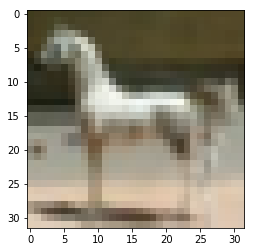

In [2]:
plt.imshow((x_train[150,:,:,:])) # Why is there a +1, /2 in the original?

In [3]:
z_dim = 100
batch_size = 64
critic_learning_rate = 0.0005
generator_learning_rate = 0.0005 # Aren't those learning rates too small?
grad_weight = 10
epochs = 6000
n_critic = 5

In [4]:
input_dim = x_train[0].shape

critic_input = Input(shape = input_dim, name = 'critic_input')

x = critic_input
x = Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = 'same', 
           name = 'critic_conv_0', kernel_initializer = 'glorot_uniform')(x)
x = LeakyReLU()(x)
x = Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same',
           name = 'critic_conv_1', kernel_initializer = 'glorot_uniform')(x)
x = LeakyReLU()(x)
x = Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = 'same',
           name = 'critic_conv_2', kernel_initializer = 'glorot_uniform')(x)
x = LeakyReLU()(x)
x = Conv2D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',
           name = 'critic_conv_3', kernel_initializer = 'glorot_uniform')(x)
x = LeakyReLU()(x)
x = Flatten()(x)
# No activation

critic_output = Dense(1, activation = None, kernel_initializer = 'glorot_uniform')(x)

critic = Model(critic_input, critic_output)

In [5]:
generator_initial_dense_layer_size = (4,4,128)
generator_input = Input(shape = (z_dim,), name = 'generator_input')

x = generator_input
x = Dense(np.prod(generator_initial_dense_layer_size),
          kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU()(x)
x = Reshape(generator_initial_dense_layer_size)(x)
x = UpSampling2D()(x)
x = Conv2D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',
           name = 'generator_conv_0', kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(filters = 64, kernel_size = 5, strides = 1, padding = 'same',
           name = 'generator_conv_1', kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same',
           name = 'generator_conv_2', kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 3, kernel_size = 5, strides = 1, padding = 'same',
                    name = 'generator_conv_3', kernel_initializer = 'glorot_uniform')(x)
x = Activation('tanh')(x)
generator_output = x

generator = Model(generator_input, generator_output)

In [6]:
# Adversarial
# Set the generator as unable to train.
# Note to self - any difference between setting the model outright untrainable vs layers
# untrainable

# See this https://github.com/keras-team/keras/blob/master/keras/layers/merge.py
# This means that RandomWeightedAverage should be used as if it was a Merge layer
class RandomWeightedAverage(_Merge):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        
    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1,1,1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

    
def gradient_penalty_loss(y_true, y_pred, interpolated_samples):
    gradients = K.gradients(y_pred, interpolated_samples)[0] # Loss first then gradient, no?
    # It should be (loss, variables)??
    gradients_sqr = K.square(gradients) # Euclidean Norm
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis = np.arange(1, len(gradients_sqr.shape))) # Sum over rows
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = K.square(1 - gradient_l2_norm) # Lambda is handled during compilation.
    
    return K.mean(gradient_penalty)

###########################
### adversarial compile ###
###########################
generator.trainable = False
for l in generator.layers:
    l.trainable = False
    
# Real image
real_img = Input(shape = input_dim)

# Fake image
z_disc = Input(shape = (z_dim,))
fake_img = generator(z_disc)

# Critic determines validity of real and fake images
fake = critic(fake_img)
valid = critic(real_img)

# Construct weighted average between real and fake images
interpolated_img = RandomWeightedAverage(batch_size = batch_size)([real_img, fake_img])
validity_interpolated = critic(interpolated_img)

partial_gp_loss = partial(gradient_penalty_loss,
                          interpolated_samples = interpolated_img)
adversarial = Model(inputs = [real_img, z_disc],
                    outputs = [valid, fake, validity_interpolated])

adversarial.compile(
    loss = [wasserstein, wasserstein, partial_gp_loss],
    optimizer = Adam(lr = critic_learning_rate),
    loss_weights = [1, 1, grad_weight]
)

#########################
### generator compile ###
#########################
critic.trainable = False
for l in critic.layers:
    l.trainable = False
    
generator.trainable = True
for l in generator.layers:
    l.trainable = True

# You have exactly the same stuff as generator, but at the end you apply the critic.
model_input = Input((z_dim,))
img = generator(model_input)
model_output = critic(img)
generator_model = Model(model_input, model_output)
generator_model.compile(optimizer = Adam(lr = generator_learning_rate),
                        loss = wasserstein)

In [7]:
%%time
# Training
d_losses = []
d_gens = []

for epoch in range(epochs):
    for _ in range(n_critic): # Training the critic
        valid = np.ones((batch_size, 1))
        fake = -np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1))
        
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        true_imgs = x_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(noise)
        d_loss = adversarial.train_on_batch(x = [true_imgs, noise],
                                            y = [valid, fake, dummy])
    # Training the generator
    valid = np.ones((batch_size,1))
    noise = np.random.randint(0, 1, (batch_size, z_dim))
    d_gen = generator_model.train_on_batch(x = noise,
                                           y = valid)
    d_losses.append(d_loss)
    d_gens.append(d_gen)
    
    if epoch % 500 == 0:
        print('Completed epoch {}'.format(epoch))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Completed epoch 0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Completed epoch 500
Completed epoch 1000
Completed epoch 1500
Completed epoch 2000
Completed epoch 2500
Completed epoch 3000
Completed epoch 3500
Completed epoch 4000
Completed epoch 4500
Completed epoch 5000
Completed epoch 5500
CPU times: user 23min 34s, sys: 4min 15s, total: 27min 50s
Wall time: 35min 28s


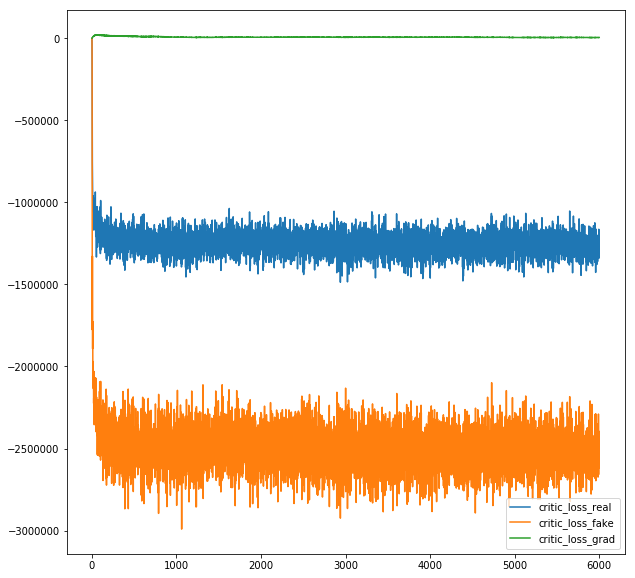

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

critic_loss_real = [i[0] for i in d_losses]
critic_loss_fake = [i[1] for i in d_losses]
critic_loss_grad = [i[2] for i in d_losses]

plt.figure(figsize = (10,10))
plt.plot(critic_loss_real, label = 'critic_loss_real')
plt.plot(critic_loss_fake, label = 'critic_loss_fake')
plt.plot(critic_loss_grad, label = 'critic_loss_grad')
plt.legend()
# Uh, I guess this means that it failed miserably in training?

In [15]:
idx = np.random.randint(low = 0, high = len(x_test), size = 10)
real_imgs = x_test[idx,:,:,:]
critic.predict(real_imgs)

array([[2444614. ],
       [2867575.2],
       [3712482.2],
       [3462630. ],
       [2875908. ],
       [2452307.2],
       [2167240.2],
       [3525378.2],
       [2221782.5],
       [3119067.2]], dtype=float32)

In [16]:
noise = np.random.normal(size = (10,z_dim))
critic.predict(generator.predict(noise)) # ARGH!

array([[4538.3364],
       [4538.3364],
       [4538.3364],
       [4538.3364],
       [4538.3364],
       [4538.3364],
       [4538.3364],
       [4538.3364],
       [4538.3364],
       [4538.3364]], dtype=float32)

In [11]:
generator.predict(noise) # Only predicting a bunch of ones, damn it.

array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 

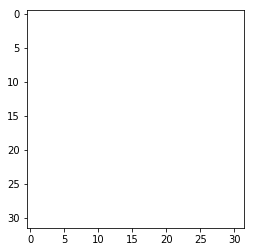

In [12]:
plt.imshow(generator.predict(noise)[1,:]) # Fu

In [20]:
critic.save('models/WGANGP_v2/critic')

In [13]:
# Try first
# Actual code uses batch norm momentum with generator and also has rms-prop instead of adam